In [ ]:
# !pipreqsnb --f
# !pip3 install -q -r requirements.txt

In [9]:
import numpy as np
import pandas as pd
%matplotlib ipympl
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import os
import itertools
PATH = "./nn"

import tqdm
import tabulate

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device, torch.__version__

('cpu', '2.1.0+cpu')

In [11]:
RSEED = 42
# smallest possible number, -inf representation on this machine
EPS = np.finfo(float).eps
EPS

2.220446049250313e-16

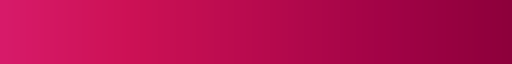

In [12]:
# create custom colormap without whites
min_val, max_val = 0.3, 1.0
n = 5
colors = plt.cm.Blues(np.linspace(min_val, max_val, n))
# create cmap object from a list of colours
import matplotlib
blues_cr = matplotlib.colors.LinearSegmentedColormap.from_list("Blues_cr", colors)
blues_cr

# create almost constant custom colormap
min_val, max_val = 0.7, 0.9
n = 5
colors = plt.cm.PuRd(np.linspace(min_val, max_val, n))

PuRd_cr = matplotlib.colors.LinearSegmentedColormap.from_list("PuRd_cr", colors)
PuRd_cr

In [13]:
def cl_plot(arr, title='Collocation data points', cm=blues_cr):
  """plots (N,3)-shaped array of points but also accepts (N,4)"""
  pos = arr.detach().numpy()

  fig = plt.figure(figsize=(6,6))
  ax = plt.axes(projection='3d')
  ax.invert_zaxis()
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z = depth');

  plt.title(title, fontsize=16)
  ax.scatter3D(pos[:,0]+1, pos[:,1]+1, pos[:,2]+1, c=pos[:,2], s=10, cmap=cm,)
  plt.show()
  return fig, ax

def add_wells(ax_object, well_coord):
  """adds well locations coloured by roles onto an existing plot"""
  inj, prd = well_coord[0].to_numpy(), well_coord[1].to_numpy()
  ax_object.scatter(inj[:,0], inj[:,1], s=60, c='green', alpha=1)
  ax_object.scatter(prd[:,0], prd[:,1], s=100, c='red', alpha=1)
  # return ax_object

In [14]:
# load data
path = "./data.csv"
df = pd.read_csv(path)
print(df.sample(5).to_markdown())
# load metadata
path = "./meta.csv"
df_coords = pd.read_csv(path)
df_coords["group"] = df_coords["cat"].str[0]
df_coords

|       | cat   | group   |   date |           oil |       water |      liquid |         bhp |   status |   start_lag |   coef | is_base   |
|------:|:------|:--------|-------:|--------------:|------------:|------------:|------------:|---------:|------------:|-------:|:----------|
|  3738 | I2    | I       |     27 | nan           |  0.001267   |  0.001267   | 3.06986e+07 |        1 |          19 |   0.17 | False     |
|  8739 | I3    | I       |      7 | nan           |  0.001254   |  0.001254   | 4.15301e+07 |        1 |           3 |   0.33 | False     |
|  4191 | P2    | P       |     28 |  -0.000250695 | -0.00226548 | -0.00251618 | 2e+07       |        1 |          10 |   0.17 | False     |
| 20223 | I2    | I       |     24 | nan           |  0.001267   |  0.001267   | 3.32648e+07 |        1 |          14 |   0.5  | False     |
|  2396 | P2    | P       |     29 |  -0.000260283 | -0.00280763 | -0.00306792 | 2e+07       |        1 |          15 |   0.42 | False     |


,cat,x,y,group
0,P1,190,190,P
1,P2,190,890,P
2,I1,890,190,I
3,I2,590,770,I
4,I3,670,510,I


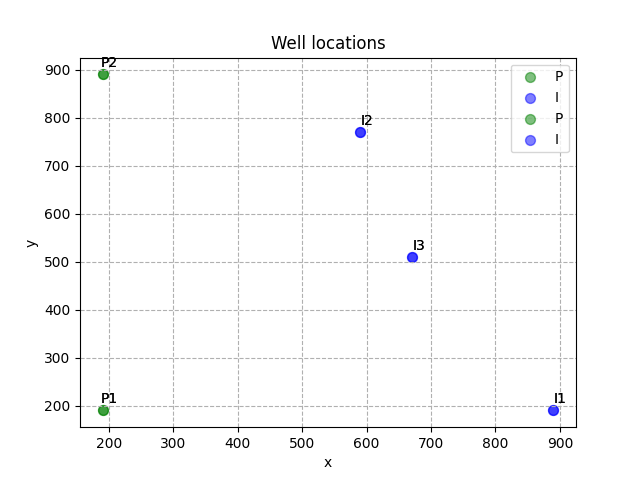

In [15]:
# create a dictionary that maps categories to colors
color_dict = {"P": "green", "I": "blue"}
# generate a scatter plot with color-coded points
for group, color in color_dict.items():
    df_cat = df_coords[df_coords["group"] == group]
    plt.scatter(df_cat["x"], df_cat["y"], s=50, alpha=0.5, color=color, label=group)

for i, row in df_coords.iterrows():
    plt.annotate(
        row["cat"],
        (row["x"], row["y"]),
        textcoords="offset points",
        xytext=(5, 5),
        ha="center",
        color="k",  # change the text color to red
    )

# add labels and legend
plt.title("Well locations")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(ls="--")
plt.legend()
plt.show()

In [ ]:
df_coords['z'] = 0
injectors = df_coords[df_coords['group']=='I'][["x","y","z"]]
producers = df_coords[df_coords['group']=='P'][["x","y","z"]]
wells = torch.Tensor(np.concatenate([injectors,producers]))
wells

In [ ]:
# liquid feature is evidently excessive cause it's linearly dependent of two others == from now on I choose to forecast just the oil pr
(df["oil"] + df["water"] - df["liquid"]).sum()
# dfv1 = df.drop(columns=["liquid"])
dfv1 = df.drop(columns=["water", 'oil'])
# also there is one column with clearly boolean values
dfv1["status"] = dfv1["status"].astype("bool")
# separate test case (3 inj wells, 2 prod wells), all normal operation except for I3
dfv1_test = dfv1[dfv1["is_base"] == False].drop(columns=["is_base"])
# we have just 3 columns that contains some NaNs
NaN_cols = dfv1_test.columns[dfv1_test.isna().any()]
# when I3 pump is turned off, those corresponding 2592 water\oil\bhp NaN values could and should be interpreted as zeros
I3_off_condition = (
    (dfv1_test[NaN_cols].isna().any(axis=1))
    & (dfv1_test["status"] == False)
    & (dfv1_test["cat"] == "I3")
)
dfv1_test[I3_off_condition] = dfv1_test[I3_off_condition].fillna(0)
# Remaining 14688 oil column NaNs are caused by injecting wells that don't produce any oil, and therefore could be set as zero
inj_wells_oil_condition = (dfv1_test[["liquid"]].isna().any(axis=1)) & (
    dfv1_test["group"] == "I"
)
dfv1_test.isna().sum()
dfv1_test[inj_wells_oil_condition] = dfv1_test[inj_wells_oil_condition].fillna(0)
# our DF hasn't been yet arranged by 'date', from now on it's sequential
dfT = dfv1_test.sort_values(by=["date"])
# --------------------------------------------------------
data_ = dfT.drop(columns=["status", 'group'])
data_ = data_.merge(right=df_coords.drop(columns=['group']), on='cat', how='left')
data_['z'] = 0
data_['v'] = 0
data_['u'] = 0

data = data_[['coef', 'start_lag', 'cat', 'u', 'v', 'liquid', 'bhp', 'x', 'y', 'z','date']].rename(columns={"date":'t', 'liquid':'w', 'bhp':'P'})
data

In [ ]:
# df_coords[df_coords['cat']=='I3'][['x','y']].values

In [ ]:
# maxes = pos[:,:3].max(axis=0)
# minis = pos[:,:3].min(axis=0)
# X, Y, Z = np.stack([minis, maxes], axis=1)
# vertices = [(x,y,z) for x in X for y in Y for z in Z]
# # just an effort to draw cuboid from a set of vertices effectively -- unused

In [ ]:
class SuDS(Dataset):
  '''receives original dataframe, separates experiments, splits 4D coordinates from fields and outputs 2 numpy arrays per experiment #part'''
  def __init__(self, data, part=0):
    super().__init__()
    # group all experimental combinations and separate from each other
    exp_g = [g.drop(columns=["coef", "start_lag",'cat']) for i, g in data.groupby(["coef", "start_lag"])]
    # exp_g[0] - 5x 4D values per each of 30 timesteps
    # exp_g[0][exp_g[0]['t'] == 0]
    self.exp_split = []
    assert part < len(exp_g), 'wrong cfg'
    # capture part of an experiment
    self.nexp = part
    for e in exp_g:
      # feature-target split dataframe, convert to numpy arrays
      e = e.reset_index()
      self.exp_split.append((torch.tensor(e[['x', 'y', 'z','t']].to_numpy(), dtype=torch.float, requires_grad=True),
                             torch.tensor(e[['u', 'v', 'w','P']].to_numpy(), dtype=torch.float, requires_grad=True)))
    print(f"We have chosen #{self.nexp} of {len(exp_g)} experiments with {len(exp_g[0])} 4D points each, splitted as f-t")
    # exp_split[0][0].shape, exp_split[0][1].shape
    # for each such experiment, we want to simulate vector streamline and scalar pressure field's evolution over time

  def __getitem__(self, idx):
    return self.exp_split[self.nexp][0][idx], self.exp_split[self.nexp][1][idx]
  def __len__(self):
    return len(self.exp_split[self.nexp][0])

In [ ]:
# suppose that the liquid has just 1 phase with constant viscosity and density
MU = 0.001 #pascal*secs
RHO = 0.997 #kg/m3
# Our model reservoir is considered to be rectangular DWL (depth=Zaxis)
L=1000
W=1000
D=500
T=30
# we have 3 inlets, 2 outlets => 5 point sources on boundary dO
# with injection/production along Z-direction, i.e. velocity_5pts = (0,0,w)

# NS problem is well-posed given all-Dirichlet boundary conditions for velocity:
# In case of incompressible fluid, we could use Poisson identity to relate
# pressure to velocity thus we don't specify any conditions for pressures

Unlike typical PDE solvers (finite-element, finite-volume) based on advanced meshgrid, PINN approach is in fact **mesh-free**, that means we could sample a random cloud $O \subset R^n$ thus skip this time-consuming step and also evade (by randomness) possible pattern priors in our solution caused by spatial grid

In [ ]:
# # we could use 4D meshgrid with an equal spacing
# xs = torch.linspace(0, L-1, steps=5)
# ys = torch.linspace(0, W-1, steps=5)
# zs = torch.linspace(0, D-1, steps=5)
ts = torch.linspace(0, T-1, steps=30)
# x, y, z, t = torch.meshgrid(xs, ys, zs, ts, indexing='xy')
# # get exact 4D coordinates instead of indexing 4x arrays simultaneously on the fly
# positions = torch.vstack(list(map(torch.ravel, (x, y, z, t)))).T
# # allow gradient computations wrt to those as inputs
# # positions.requires_grad_()

In [ ]:
def disjoin(left, right, invert=False):
  """this function provides split of disjoint union of non-intersection for 2D tensors"""
  # difference of two tensors ~ elements that appear just once in their cat
  combined = torch.cat((left, right))
  # get unique 4D rows, counts[e] == 1 means that uniques[e] is unique
  # idx is a lookup table orig_idx --> #bin w/ one (or more) elements
  uniques_, idx, counts_ = combined.unique(return_counts=True, return_inverse=True, dim=0)
  # for now that's a disjoint union w/ elements of both sets, let's filter out
  # list counts per each element of combined tensor, mask out unique elements
  counts = counts_[idx] == 1
  # left, right unique elements masks (false for idx_e if e in intersection)
  lu, ru = counts[:len(left)], counts[len(left):]
  # apply masks to both sides correspondingly
  if invert:
    # allows to get their intersection (splitted!)
    lu, ru = ~lu, ~ru
  lu_idx, ru_idx = torch.arange(len(left))[lu], torch.arange(len(right))[ru]
  # diff = uniques_[counts_ == 1]
  # we won't use uniques, just counts for masking out NSE results
  def aux(lst):
    check = True if len(lst)!=0 else False
    if check:
      # returns tensor w/ unique indices
      return lst
    else:
      #returns None by default
      print('given tensors contain one another or no intersection')
  return aux(lu_idx), aux(ru_idx)

# disjoin(initial[100:], initial, True)[0]
# initial[100:].shape

In [ ]:
N_COLL = 100
# Likewise, just create uniformly-distributed cloud of 3D points and stretch
torch.manual_seed(RSEED)
cloud = torch.rand(N_COLL, 3)@torch.diag(torch.Tensor((L,W,D)))

In [ ]:
# let's generate and put apart whole border dO to evade conditions in training loop
N_BOR = 36
# max amount of border points (equally distributed across all 6 planes)
limits = torch.Tensor((L,W,D))
planes = []
for axis in range(3):
  rest = list(range(3))
  del rest[axis]
  curr_limits = limits[rest]
  for wall in set((0, limits[axis])):
    normal = torch.ones((N_BOR//6, 1))*wall
    # generate points on the plane
    torch.manual_seed(RSEED)
    plane = torch.split(torch.rand(N_BOR//6,2)@torch.diag(torch.Tensor(limits[rest])), 1, dim=1)
    # retain XYZ order with a help of dict
    parts = {axis:normal, rest[0]:plane[0], rest[1]: plane[1]}
    triplets = [parts[idx] for idx in range(3)]
    planes.append(torch.cat(triplets, dim=-1))
border = torch.cat(planes, dim=0)

# ensure that wells don't coincide with collocation points jic
assert disjoin(border, wells, True)[0] is None, 'border points fail'

In [ ]:
# cloud visualization
fa = cl_plot(cloud, 'Collocation random cloud (interior)')
add_wells(fa[1], (injectors, producers))

In [ ]:
fa_b = cl_plot(border, 'Border points', cm=PuRd_cr)
add_wells(fa_b[1], (injectors, producers))

In [ ]:
print(f'We have {border.shape[0]:.0f} border points dO and {cloud.shape[0]:.0f} interior points in our grid O')
# use same cloud at each timestep
clouds = cloud.unsqueeze(-1).repeat(1,1,T)
# transform and duplicate time axis such that ts[0, :, 5] = 5th timestep
times = ts[(None,)*2].repeat(cloud.shape[0],1,1)
# concatenate, merge time and count dimension into a single batch dimension
positions = torch.flatten(torch.cat((clouds, times), dim=1).permute(0,2,1), 0, 1)

# use same border at each timestep
borders = border.unsqueeze(-1).repeat(1,1,T)
times = ts[(None,)*2].repeat(border.shape[0],1,1)
positions_b = torch.flatten(torch.cat((borders, times), dim=1).permute(0,2,1), 0, 1)

# our initial condition requires all O and dO elements with T=0, 5^3 pts
initial = positions[positions[:,3]==0]

# enable gradient computation in regard to all these
# positions.requires_grad_()
# positions_b.requires_grad_()
# initial.requires_grad_()
collocation = torch.cat((positions, positions_b), dim=0)
collocation.requires_grad_()
# collocation.shape
print('Gradients enabled')

# positions.shape, positions_b.shape, initial.shape

Data = Supervised(original) + Unsupervised(generated,collocation)

Supervised data contains just 5pts on boundary dO of our reservoir O (but 30 timesteps)

Unsupervised data contains the rest boundary dO(walls) and int(O) volume

In [ ]:
#create dataset and dataloaders
uns_dl = DataLoader(collocation, shuffle=True, batch_size=len(collocation))

supervised_data = SuDS(data, part=0)
sup_dl = DataLoader(supervised_data, batch_size=len(supervised_data))
# next(iter(sup_dl))[0].requires_grad

In [ ]:
def NS_equation(point_4d, net_function, viscosity=MU, density=RHO, la=None):
  """takes net output, performs differentiation by inputs and
  calculates the residual of Navier-Stokes 3D ODE at this point"""
  # WE CAN'T USE SLICES=VIEWS OF INPUTS CAUSE IT BREAKS AUTOGRAD
  # x, y, z, t = torch.split(point_4d, 1, dim=1)
  # possible degrees of freedom - learnable parameters for NSE
  if la:
    lambda_1 = la[0]
    lambda_2 = la[1]
  else:
    lambda_1=lambda_2=torch.tensor(1, dtype=torch.float, requires_grad=True)
  # net outputs include batch dimension
  Ax, Ay, Az, p_field = torch.split(net_function, 1, dim=1)
  # we can calculate the gradient of pressure field immediately (3D only!)
  gr_p = torch.autograd.grad(p_field, point_4d, grad_outputs=torch.ones_like(p_field), create_graph=True)[0][:,:3]
  # we want (vector) velocity field to automatically satisfy continuity equation,
  # suppose we have vector potential, C2-diff 3D vector field A => div(rotA)=0
  # implying that, reconstruct our velocity_field from its vector potential
  # thus rewrite velocity = rot A in a component form:
  # INEFFICIENT, TO BE REPLACED BY FUNCTIONAL JACOBIAN
  gr_Ax = torch.autograd.grad(Ax, point_4d, grad_outputs=torch.ones_like(Ax), create_graph=True)[0]
  Ax_y, Ax_z = gr_Ax[:,1], gr_Ax[:,2]
  gr_Ay = torch.autograd.grad(Ay, point_4d, grad_outputs=torch.ones_like(Ay), create_graph=True)[0]
  Ay_x, Ay_z = gr_Ay[:,0], gr_Ay[:,2]
  gr_Az = torch.autograd.grad(Ay, point_4d, grad_outputs=torch.ones_like(Az), create_graph=True)[0]
  Az_x, Az_y = gr_Az[:,0], gr_Az[:,1]
  u, v, w = Az_y - Ay_z, Ax_z - Az_x, Ay_x - Ax_y
  velocity_field = torch.stack((u, v, w), dim=-1)
  # for correctness of future elementwise multiplication
  u, v, w = u.unsqueeze(-1), v.unsqueeze(-1), w.unsqueeze(-1)
  # then we need their first-order derivatives
  gr_u = torch.autograd.grad(u, point_4d, grad_outputs=torch.ones_like(u), create_graph=True)[0]
  u_x, u_y, u_z, u_t = torch.split(gr_u, 1, dim=1)
  gr_v = torch.autograd.grad(v, point_4d, grad_outputs=torch.ones_like(v), create_graph=True)[0]
  v_x, v_y, v_z, v_t = torch.split(gr_v, 1, dim=1)
  gr_w = torch.autograd.grad(w, point_4d, grad_outputs=torch.ones_like(w), create_graph=True)[0]
  w_x, w_y, w_z, w_t = torch.split(gr_w, 1, dim=1)
  # and unmixed 2nd-order derivatives to form vector laplacian
  u_xx = torch.autograd.grad(u_x, point_4d, grad_outputs=torch.ones_like(u_x), retain_graph=True)[0][:,0]
  u_yy = torch.autograd.grad(u_y, point_4d, grad_outputs=torch.ones_like(u_y), retain_graph=True)[0][:,1]
  u_zz = torch.autograd.grad(u_z, point_4d, grad_outputs=torch.ones_like(u_z), retain_graph=True)[0][:,2]

  v_xx = torch.autograd.grad(v_x, point_4d, grad_outputs=torch.ones_like(v_x), retain_graph=True)[0][:,0]
  v_yy = torch.autograd.grad(v_y, point_4d, grad_outputs=torch.ones_like(v_y), retain_graph=True)[0][:,1]
  v_zz = torch.autograd.grad(v_z, point_4d, grad_outputs=torch.ones_like(v_z), retain_graph=True)[0][:,2]

  w_xx = torch.autograd.grad(w_x, point_4d, grad_outputs=torch.ones_like(w_x), retain_graph=True)[0][:,0]
  w_yy = torch.autograd.grad(w_y, point_4d, grad_outputs=torch.ones_like(w_y), retain_graph=True)[0][:,1]
  w_zz = torch.autograd.grad(w_z, point_4d, grad_outputs=torch.ones_like(w_z), retain_graph=True)[0][:,2]
  # now we are ready to use NS, start from diffusion terms:
  DTx = (viscosity/density)*(u_xx+u_yy+u_zz)
  DTy = (viscosity/density)*(v_xx+v_yy+v_zz)
  DTz = (viscosity/density)*(w_xx+w_yy+w_zz)
  # convection terms
  CTx = (u*u_x+v*u_y+w*u_z).squeeze()
  CTy = (u*v_x+v*v_y+w*v_z).squeeze()
  CTz = (u*w_x+v*w_y+w*w_z).squeeze()
  # this results in 3D NS residuals implying continuity part by construction
  Rx = u_t.squeeze() + lambda_1*CTx - DTx + lambda_2*gr_p[:,0]/density
  Ry = v_t.squeeze() + lambda_1*CTy - DTy + lambda_2*gr_p[:,1]/density
  Rz = w_t.squeeze() + lambda_1*CTz - DTz + lambda_2*gr_p[:,2]/density
  residuals = torch.stack((Rx, Ry, Rz), dim=-1)
  return velocity_field, residuals

In [ ]:
class NSE_lambda(nn.Module):
  """NSE with additional learnable parameters injected"""
  def __init__(self):
    super().__init__()
    self.la_1 = nn.Parameter(torch.tensor(1.))
    self.la_2 = nn.Parameter(torch.tensor(1.))

  def forward(self, net_in, net_out):
    return NS_equation(net_in, net_out, la=(self.la_1, self.la_2))

In [ ]:
from torch.nn.modules.activation import Sigmoid
class PINNNS(nn.Module):
  """Navier-Stokes physics-informed NN
  4D -> 3D streamline potential + scalar pressure fields"""
  def __init__(self, n_hidden=48, nonlinearity=nn.Sigmoid()):
    super().__init__()
    # inputs are 4D spatial coordinates x,y,z,t
    self.n_inp = 4
    # outputs are 3D velocity field potential (Ax, Ay, Az) and scalar pressure field P
    self.n_out = 4
    self.n_hid = n_hidden
    self.nonlinear = nonlinearity
    self.inp = nn.Linear(in_features=self.n_inp, out_features=self.n_hid)
    self.inter = nn.Sequential(
        nn.Linear(self.n_hid, self.n_hid),
        self.nonlinear,
        nn.Linear(self.n_hid, self.n_hid),
        self.nonlinear,
    )
    self.out = nn.Linear(in_features=self.n_hid, out_features=self.n_out)
  def forward(self, x):
    return self.out(self.inter(self.nonlinear(self.inp(x))))
    # return self.out(self.nonlinear(self.inp(x)))

In [ ]:
def RMSE_f(inp, tar):
  return torch.sqrt(torch.nn.functional.mse_loss(inp, tar))

# loss = Loss_data + Loss_NS3D + Loss_boundary + Loss_initial
def supervised_loss(net_in, net_out, target, lambda_mode=False):
  """combined loss at single 4D point net_in, calculated as Loss_data + Loss_NS3D on data"""
  # get (vector of) velocity and residuals
  if lambda_mode:
    velocity, residuals = lambda_mode(net_in, net_out)
  else:
    velocity, residuals = NS_equation(net_in, net_out)
  # separate pressure to stack with velocity instead of its potential
  pressure = net_out[:,3].unsqueeze(-1)
  net_out_v = torch.cat((velocity, pressure), dim=-1)
  # we have 5 wells, each has velocity and pressure data (supervised loss)
  data_loss = torch.mean(RMSE_f(net_out_v, target))/1e07
  # moreover, they should obey NS3D as a part of boundary and initial condition
  NS3D_loss = torch.mean(torch.norm(residuals, dim=-1))
  return data_loss + NS3D_loss

def unsupervised_batch_loss(net_in, net_out, lambda_mode=False):
  """process whole batch and filter out proper results by mask"""
  if lambda_mode:
    velocity, residuals = lambda_mode(net_in, net_out)
  else:
    velocity, residuals = NS_equation(net_in, net_out)
  loss_0, loss_i = torch.tensor(0.), torch.tensor(0.)
  # We have initial conditions on velocity
  # velocity_5pts = (0,0,w) in supervised, velocity_else = (0,0,0) in both O and dO
  # intersect batch w/ initial
  s_mask = disjoin(net_in, initial, True)[0]
  if s_mask is not None:
    loss_0 = torch.mean(torch.norm(velocity[s_mask], dim=-1))
  # We have initial conditions on border
  # dO/5pts follows non-slip and impermeability BC, i.e. vel_b_rest = (0,0,0)
  # intersect batch w/ boundary
  b_mask_ = disjoin(net_in, positions_b, True)[0]
  # purify to exclude possible init points on boundary(already processed)
  b_mask = disjoin(b_mask_, s_mask)[0]
  if b_mask is not None:
    loss_b = torch.mean(torch.norm(velocity[b_mask], dim=-1))
  # the rest is NSE3D loss on O (not masked = at any timestep and location)
  loss_i = torch.mean(torch.norm(residuals, dim=-1))
  return loss_0 + loss_b + loss_i

In [ ]:
def train(model, dl_original, dl_collocation, optimizer, n_epochs=300, gpu=device, beta=torch.tensor(0.5), la=None):
  """training loop for PINN model with weight updates per epoch,
  beta in [0,1] is a hyperparameter relating losses of different origin,
  larger beta <=> more unsupervised"""
  epochs = tqdm.trange(n_epochs)
  losses = []
  for e in epochs:
    model.train()
    # this optimizer calls closure multiple times!!
    def closure():
      """A closure callback that reevaluates the model and returns the loss
      backprop, zeroing gradients is embedded into closure callback for LBFGS,
      forward has been put here too cause otherwise it doesn't work"""
      # these losses are implemented like that just in case we will use batches
      # u_loss = torch.tensor(0., device=gpu)
      # s_loss = torch.tensor(0., device=gpu)

      # forward pass A
      for X_batch, y_batch in dl_original:
        # NOT ACTUALLY BATCHED FOR LBFGS (FULL BM)
        X_batch, y_batch = X_batch.to(gpu), y_batch.to(gpu)
        y_pred = model(X_batch)
        s_loss = supervised_loss(X_batch, y_pred, y_batch, lambda_mode=la)# + s_loss
      # forward pass B
      for X_batch_B in dl_collocation:
        # NOT ACTUALLY BATCHED FOR LBFGS (FULL BM)
        X_batch_B = X_batch_B.to(gpu)
        y_pred_B = model(X_batch_B)
        u_loss = unsupervised_batch_loss(X_batch_B, y_pred_B, lambda_mode=la)#+ u_loss
      # print('\n Collocation stage')

      # sum up both losses with adjustments
      loss = (1.-beta)*s_loss/len(dl_original) + beta*u_loss/len(dl_collocation)
      # print(s_loss.item(), u_loss.item(), loss.item())
      # prevent accumulation of gradients from prev steps
      optimizer.zero_grad()
      # backward pass
      loss.backward()
      losses.append(loss.item())
      return loss

    # gradient update
    optimizer.step(closure)

    if e % 10 == 0:
      model.eval()
      with torch.inference_mode():
        # print(losses[-1])
        epochs.set_description(f"test loss: {losses[-1]:g}", refresh=True)

In [ ]:
N_EPOCHS = 300
PHYS_FACTOR = 0.2

torch.manual_seed(RSEED)
# torch.autograd.set_detect_anomaly(False)

pinny = PINNNS().to(device)
# equip NSE with learnable parameters
nsel = NSE_lambda()
# chain two generators (or just conv to list and join, use as iterable)
learnable_params = itertools.chain(pinny.parameters(), nsel.parameters())
# not recommended to use SGD or any batch methods as they tend to stuck in a local minima
# optimizer = torch.optim.SGD(pinny.parameters(), lr=0.1)
optimizer = torch.optim.LBFGS(learnable_params, lr=0.8, max_iter=200000,
                              max_eval=50000, history_size=50,
                              tolerance_grad=3e-05,
                              tolerance_change=0.5*EPS,
                              line_search_fn='strong_wolfe')

In [ ]:
x=next(iter(sup_dl))[0]
# NS_equation(x, pinny(x))
summary(pinny, x.shape)

In [ ]:
train(pinny, sup_dl, uns_dl, optimizer, N_EPOCHS, device, PHYS_FACTOR, la=nsel)

In [ ]:
for name, param in nsel.named_parameters():
  if param.requires_grad:
    print(name, param.data)

In [ ]:
def get_stream(model, la_nse, dl):
  model.eval()
  model.cpu()
  # with torch.inference_mode():
  for X in dl:
    # Full-batch mode
    y = model(X)
    # pressure scalar field contains as is
    pressure = y[:,3]
    # apply NSE with lambda-corrections to retrieve velocity
    velocity, residuals = la_nse(X, y)
    return velocity

# get_stream(pinny, nsel, uns_dl)

def plot_vf(coord_4, field_3, moment=0):
  # get all field vectors, for all points and timesteps
  pos = coord_4.detach()
  field = field_3.detach()
  # mask out exact timestep using 4D array
  t_mask = pos[:,3] == moment
  # apply same mask to both arrays to get corresponding parts, conv to numpy
  x, y, z, t = np.split(pos[t_mask].numpy(), range(1,4), axis=1)
  u, v, w = np.split(field[t_mask].numpy(), range(1,3), axis=1)
  # configure axes and aux data
  fig = plt.figure(figsize=(6,6))
  ax = plt.axes(projection='3d')
  ax.invert_zaxis()
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z = depth');
  plt.title('Reservoir model grid', fontsize=16)

  # add 5 wells
  add_wells(ax, (injectors, producers))

  # plot grid w/ depth
  reservoir = ax.scatter3D(x, y, z, c=z, s=10, cmap=blues_cr)

  # plot streamline field
  return ax.quiver(x, y, z, u, v, w, length=50, normalize=True, color='darkviolet')

In [ ]:
plot_vf(collocation, get_stream(pinny, nsel, uns_dl),5)